In [1]:
import librosa
import matplotlib.pyplot as plt
# from librosa import display
import os
import json
import pandas as pd
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# loading dictionaru with translated letters to morse code
with open('./../../data_scripts/morse_code.json', "r", encoding='utf-8') as file:
    morse_code = json.load(file)

In [3]:
from_morse = {}
for key, value in morse_code.items():
    from_morse[value] = key

In [4]:
#  translating sentances into morse code
def translator_from_text(text):
    return " ".join("_".join([",".join([i for i in morse_code.get(i)]) for i in word]) for word in text.upper().split(" "))

In [5]:
#  translating sentances into morse code
def translator_from_morse(text):
    return " ".join(["".join([from_morse.get("".join(sign.split(","))) for sign in word.split("_")]) for word in text.split(" ")])

In [6]:
# loading dictionaru with translated letters to morse code
with open('./../../data/labels/labels_test.json', "r", encoding='utf-8') as file:
    labels = json.load(file)

In [13]:
existing_file_path = "./../../data/audio/morse_text_audio_files_test/clap/4_clap.wav"
samples, sampling_rate = librosa.load(existing_file_path, sr=5500, mono=True, offset=0.0
                        , duration=None)

In [518]:
# existing_file_path = "/Users/zuzannaglinka/Downloads/morse1dow.wav"
# samples, sampling_rate = librosa.load(existing_file_path, sr=5500, mono=True, offset=0.0
                        # , duration=None)

In [16]:
def dict_class_to_morse(cluster_centers):
    dict = {}
    if len(cluster_centers[cluster_centers > 0]) == 1 and len(cluster_centers[cluster_centers < 0]) == 1:
        dict[0] = ','
        dict[1] = '.'
    elif len(cluster_centers[cluster_centers > 0]) == 1 and len(cluster_centers[cluster_centers < 0]) == 2:
        if abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][0]>abs(cluster_centers[1]):
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '.'
        elif abs(cluster_centers[0]) < cluster_centers[cluster_centers>0][0]:
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '-'
    elif len(cluster_centers[cluster_centers > 0]) == 2 and len(cluster_centers[cluster_centers < 0]) == 1:
        if abs(cluster_centers[0]) < cluster_centers[cluster_centers>0][0]:
            dict[0] = ','
            dict[1] = '.'
            dict[2] = '-'
        elif abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][0]:
            dict[0] = '_'
            dict[1] = '.'
            dict[2] = '-'
        elif abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][1]:
            dict[0] = ' '
            dict[1] = '.'
            dict[2] = '-'
    elif len(cluster_centers[cluster_centers > 0]) == 2 and len(cluster_centers[cluster_centers < 0]) == 2:
        if abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][1] and cluster_centers[cluster_centers>0][1] > abs(cluster_centers[1]) > cluster_centers[cluster_centers>0][0]:
            dict[0] = ' '
            dict[1] = '_'
            dict[2] = '.'
            dict[3] = '-'
        elif  cluster_centers[cluster_centers>0][0] < abs(cluster_centers[0]) < cluster_centers[cluster_centers>0][1] and abs(cluster_centers[1]) < cluster_centers[cluster_centers>0][0]:
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '.'
            dict[3] = '-'
        elif  abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][1] and abs(cluster_centers[1]) < cluster_centers[cluster_centers>0][0]:
            dict[0] = ' '
            dict[1] = ','
            dict[2] = '.'
            dict[3] = '-'

    elif len(cluster_centers) == 5:
        dict[0] = ' '
        dict[1] = '_'
        dict[2] = ','
        dict[3] = '.'
        dict[4] = '-'
    return dict

In [17]:
def sound_translator(path):
    samples, sampling_rate = librosa.load(path, sr=5500, mono=True, offset=0.0
                        , duration=None)
    new_samples = ((pd.Series(samples) - min(samples)) * (1 - (-1))) / (max(samples) - min(samples)) + (-1)
    bin_samples = [1 if abs(new_val)>0.05 else 0 for new_val in new_samples]
    bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
    new_bin_samples =  [1 for i in range(20)] + \
    [(1 if (bin_samples[i] ==1 or (np.sum(bin_samples[i-20:i]) > 0 and np.sum(bin_samples[i:i+20]) > 0)) else 0) \
     for i in list(range(20, len(bin_samples)-20))] + \
          [1 for i in range(20)]
    
    new_list = []
    k = 0
    for i in range(len(new_bin_samples)-1):
        if new_bin_samples[i] != new_bin_samples[i+1]:
            if new_bin_samples[i] == 1:
                new_list.append(i-k+1)
            else:
                new_list.append(-(i+1-k))
            k = i 
    new_list.append(len(new_bin_samples)-k)

    kmeans_kwargs = {
   "init": "random",
   "n_init": 5,
   "max_iter": 300,
   "random_state": 42,
   }

    silhouette_coefficients = []
    for k in range(2, 6):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(np.array(new_list).reshape(1,-1).T)
        score = silhouette_score(np.array(new_list).reshape(1,-1).T, kmeans.labels_)
        silhouette_coefficients.append(score)

    n_clust = silhouette_coefficients.index(max(silhouette_coefficients))+2
    kmeans = KMeans(n_clusters=n_clust, **kmeans_kwargs)
    kmeans.fit(np.array(new_list).reshape(1,-1).T)
   
    cB0 = kmeans.fit_predict(np.array(new_list).reshape(1,-1).T)
    ord_idx=np.argsort(kmeans.cluster_centers_.flatten())
    cntrs = np.zeros_like(cB0)-1
    for i in np.arange(n_clust):
        cntrs[cB0==ord_idx[i]]=i

    dict = dict_class_to_morse(np.sort(kmeans.cluster_centers_.T).T)
    print("".join([dict.get(i) for i in cntrs]))
    return translator_from_morse("".join([dict.get(i) for i in cntrs]))

In [18]:
sound_translator("/Users/zuzannaglinka/Downloads/koza_jest_fajna.wav")

-,.,-_-,-,-_-,-,.,._.,- .,-,-,-_._.,.,._- .,.,-,._.,-_.,-,-,-_-,._.,-


'KOZA JEST FAJNA'

In [19]:
# sound_translator("/Users/zuzannaglinka/Downloads/morse3dow.wav")

In [20]:
sound_translator("./../../data/audio/morse_text_audio_files_test/clap/5_clap.wav")

-,-,-_.,.,-,. -_.,.,.,._. .,.,.,-_.,._._.,-,- .,.,._-_.,.,-_-,._-,._._-,.,.


'OF THE VIEW STUNNED'

In [21]:
# new_samples = ((pd.Series(samples1) - min(samples1)) * (1 - (-1))) / (max(samples1) - min(samples1)) + (-1)
new_samples = ((pd.Series(samples) - min(samples)) * (1 - (-1))) / (max(samples) - min(samples)) + (-1)


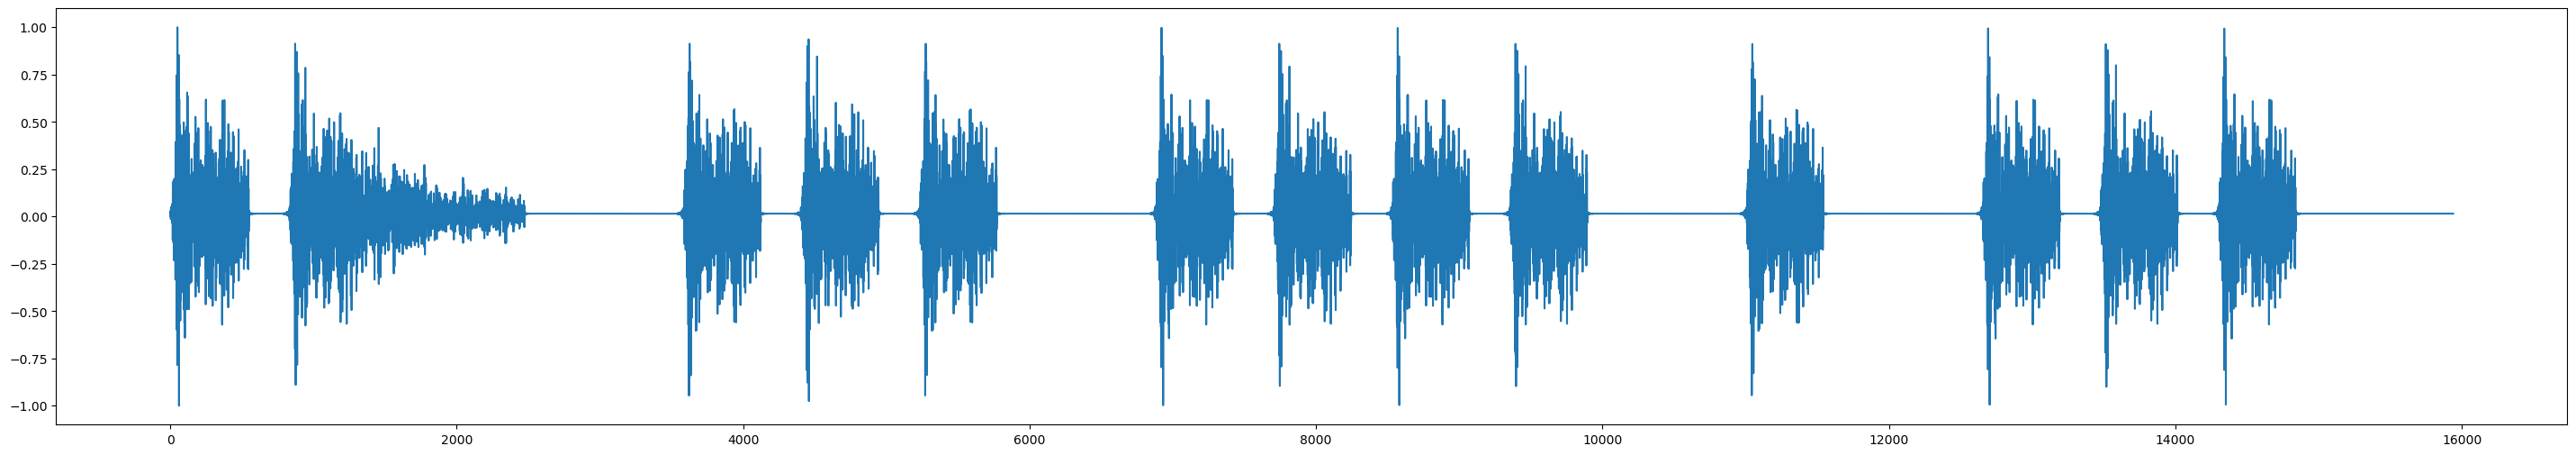

In [22]:
fig = plt.figure(figsize=(36, 6))
plt.plot(new_samples)


In [23]:
bin_samples = [1 if abs(new_val)>0.05 else 0 for new_val in new_samples]
# usuwanie ciszy na koncu i na poczatku pliku 
bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]

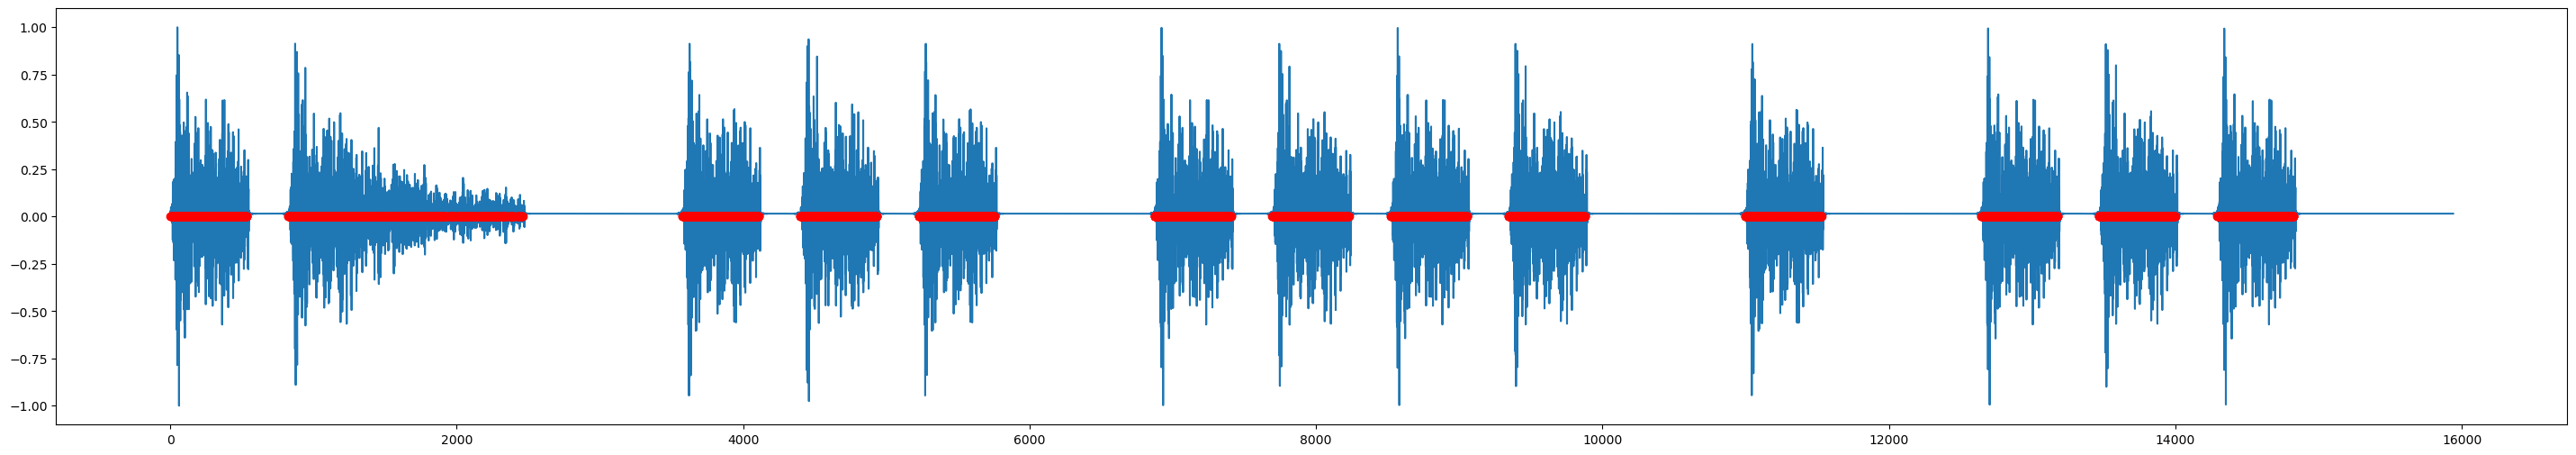

In [24]:
fig = plt.figure(figsize=(36, 6))
plt.scatter([i for i, e in enumerate(bin_samples) if e == 1], [0 for i in bin_samples if i ==1],color = 'red', zorder =2)
plt.plot(range(len(new_samples)), new_samples, zorder = 1)
plt.show()

In [25]:
new_bin_samples =  [1 for i in range(20)]+ [(1 if (bin_samples[i] ==1 or (np.sum(bin_samples[i-20:i]) > 0 and np.sum(bin_samples[i:i+20]) > 0)) else 0) for i in list(range(20, len(bin_samples)-20))] + [1 for i in range(20)]

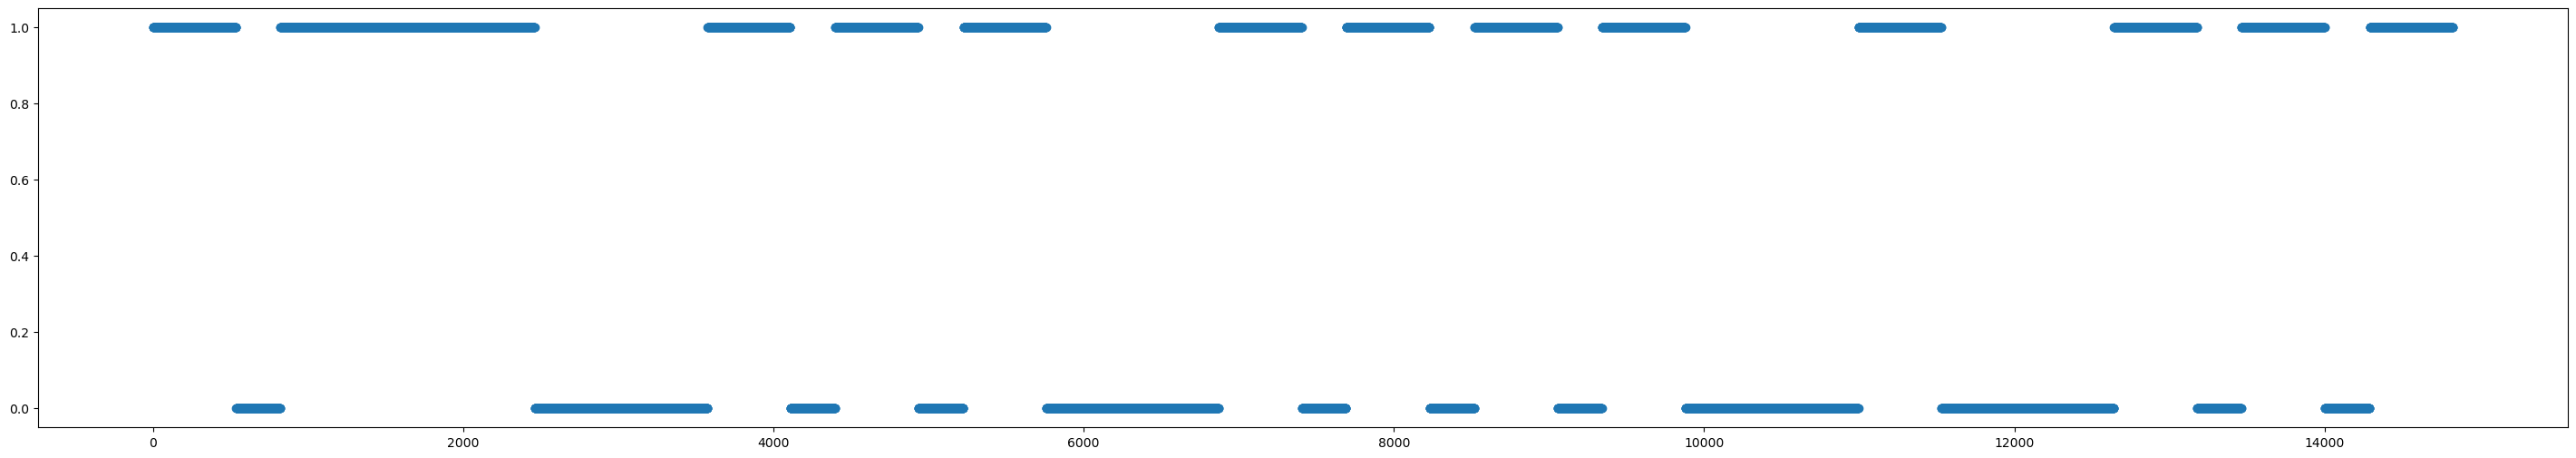

In [26]:
fig = plt.figure(figsize=(36, 6))
plt.scatter(range(len(new_bin_samples)), new_bin_samples)

In [27]:
new_list = []
k = 0
for i in range(len(new_bin_samples)-1):
    if new_bin_samples[i] != new_bin_samples[i+1]:
        if new_bin_samples[i] == 1:
            new_list.append(i-k+1)
        else:
            new_list.append(-(i+1-k))
        k = i 
new_list.append(len(new_bin_samples)-k)

(array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 534.  ,  556.14,  578.28,  600.42,  622.56,  644.7 ,  666.84,
         688.98,  711.12,  733.26,  755.4 ,  777.54,  799.68,  821.82,
         843.96,  866.1 ,  888.24,  910.38,  932.52,  954.66,  976.8 ,
         998.94, 1021.08, 1043.22, 1065.36, 1087.5 , 1109.64, 1131.78,
        1153.92, 1176.06, 1198.2 , 1220.34, 1242.48, 1264.62, 1286.76,
        1308.9 , 1331.04, 1353.18, 1375.32, 1397.46, 1419.6 , 1441.74,
        1463.88, 1486.02, 1508.16, 1530.3 , 1552.44, 1574.58, 1596.72,
        1618.86, 1641.  ]),
 <BarContainer object of 50 artists>)

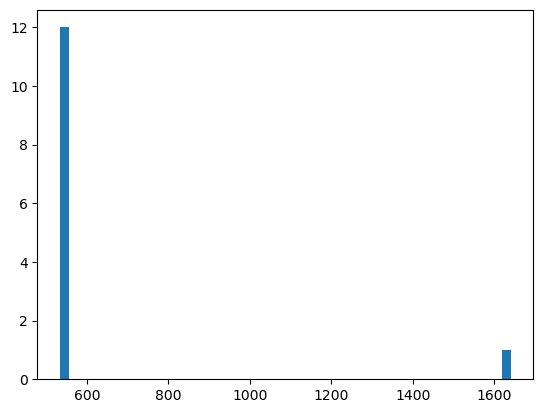

In [28]:
plt.hist([i for i in new_list if i >0], 50)

In [29]:
kmeans_kwargs = {
   "init": "random",
   "n_init": 5,
   "max_iter": 300,
   "random_state": 42,
   }

silhouette_coefficients = []
for k in range(2, 6):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
   kmeans.fit(np.array(new_list).reshape(1,-1).T)
   score = silhouette_score(np.array(new_list).reshape(1,-1).T, kmeans.labels_)
   silhouette_coefficients.append(score)

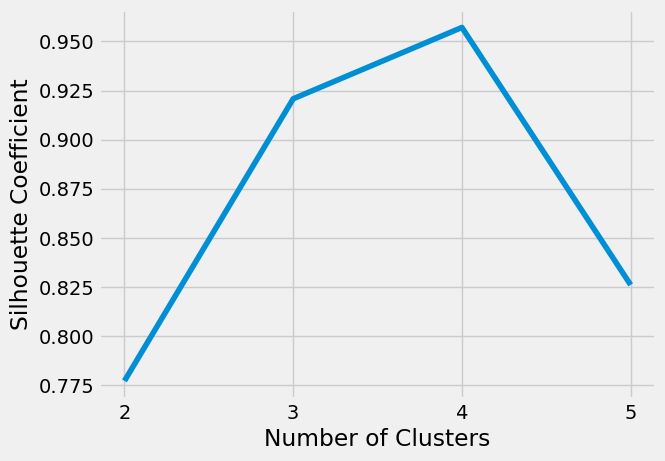

In [30]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 6), silhouette_coefficients)
plt.xticks(range(2, 6))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [31]:
silhouette_coefficients

[0.7771106924964768, 0.9208019208065285, 0.957121226913666, 0.8260200016834902]

In [32]:
n_clust = silhouette_coefficients.index(max(silhouette_coefficients))+2
kmeans = KMeans(n_clusters=n_clust, **kmeans_kwargs)
kmeans.fit(np.array(new_list).reshape(1,-1).T)

KMeans(init='random', n_clusters=4, n_init=5, random_state=42)

In [33]:
# The lowest SSE value
kmeans.inertia_

101.66666666666669

In [34]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[-1115.5       ],
       [ -288.5       ],
       [  536.66666667],
       [ 1641.        ]])

In [36]:
cB0 = kmeans.fit_predict(np.array(new_list).reshape(1,-1).T)
ord_idx=np.argsort(kmeans.cluster_centers_.flatten())
cntrs = np.zeros_like(cB0)-1
for i in np.arange(n_clust):
    cntrs[cB0==ord_idx[i]]=i

print(cntrs)

[2 1 3 0 2 1 2 1 2 0 2 1 2 1 2 1 2 0 2 0 2 1 2 1 2]


In [37]:
kmeans.cluster_centers_ = np.sort(kmeans.cluster_centers_.T).T

In [38]:
kmeans.labels_

array([2, 1, 3, 0, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2, 1,
       2, 1, 2], dtype=int32)

In [39]:
class_to_sign = dict_class_to_morse(kmeans.cluster_centers_)

In [40]:
sign_to_class = {}
for key, value in class_to_sign.items():
    sign_to_class[value] = key

In [41]:
sign_to_class

{'_': 0, ',': 1, '.': 2, '-': 3}

In [42]:
df = pd.DataFrame(columns = ['length', 'class'])
df['length'] = new_list
df['class'] = cntrs
df.head(15)

,length,class
0,536,2
1,-286,1
2,1641,3
3,-1116,0
4,534,2
5,-290,1
6,537,2
7,-292,1
8,534,2
9,-1114,0


In [44]:
# "".join([class_to_sign.get(i) for i in cntrs])

'.,-_.,.,._.,.,.,._._.,.,.'

In [46]:
translator_from_morse("".join([class_to_sign.get(i) for i in cntrs]))

'ASHES'